<a href="https://colab.research.google.com/github/bartwronski/BlogPostsExtraMaterial/blob/master/Jax_Void_and_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import random

"Simplified" void and cluster method.
1. Initialize the pattern to a few random seed pixels. This is necessary as the algorithm is fully deterministic otherwise, so without seeding it with randomness, it would produce a regular grid.
2. Repeat until all pixel set:
  1. Find empty pixel with smallest energy.
  2. Set this pixel to the index of added point.
  3. Add energy contribution of this pixel to the accumulated LUT.
  4. Repeat until all pixels are set.

In [23]:
def void_and_cluster(size, sigma = 1.9, seed_points_per_dim = -1):
  # The number of seed points will be seed_points_per_dim * seed_points_per_dim.
  # By default 1 in 8 points per axis will be a seed point, feel free to play around.
  if seed_points_per_dim < 0:
    seed_points_per_dim = max(size // 8, 1)
  
  # Construct the precomputed energy LUT.
  # This has maximum energy at (0,0) and after size/2 "mirrors" to corresponds to
  # toroidally wrapped pattern.
  wrapped_pattern = np.hstack((np.linspace(0, size/2-1, size//2), np.linspace(size/2, 1, size//2)))
  wrapped_pattern = np.exp(-0.5 * wrapped_pattern * wrapped_pattern / (sigma * sigma))
  wrapped_pattern = np.outer(wrapped_pattern, wrapped_pattern)

  # A trick / hack to simplyify the algorithm a lot.
  # Instead of tracking empty vs used pixels, simply put 'inf' there.
  # This way their energy will never be the lowest until whole array is empty.
  wrapped_pattern[0, 0] = np.inf
  lut = jnp.array(wrapped_pattern)
  jax.device_put(lut)

  # Helper function that gives final energy for a point with position given by
  # tuple pos_xy_source.
  def energy(pos_xy_source):
    return jnp.roll(lut, shift=(pos_xy_source[0], pos_xy_source[1]), axis=(0, 1))

  # For seeding I used a jittered grid. Guarantees an "ok" not too clumped
  # initialization.
  points_set = []
  bucket_size = size // seed_points_per_dim
  for x in range(0, seed_points_per_dim):
    for y in range(0, seed_points_per_dim):
      points_set.append((random.randint(x * bucket_size, ((x + 1) * bucket_size - 1)),
                         random.randint(y * bucket_size, ((y + 1) * bucket_size - 1))))
  points_set = np.random.permutation(points_set)
  
  energy_current = jnp.array(sum(energy(p) for p in points_set))
  jax.device_put(energy_current)

  # Helper function for energy updates. Finds pixel with lowest energy, and
  # updates the energy map to contain it.
  @jax.jit
  def update_step(energy_current):
    pos_flat = energy_current.argmin()
    pos_x, pos_y = pos_flat // size, pos_flat % size
    return energy_current + energy((pos_x, pos_y)), pos_x, pos_y

  # Initialize final output blue noise texture.
  final_res = np.zeros_like(lut)
  init_size = seed_points_per_dim * seed_points_per_dim
  for i, p in enumerate(points_set):
    final_res[p[0], p[1]] = i
  
  # Our whole optimization is trivial - update energy, update blue noise texture.
  for x in range(size * size - init_size):
    energy_current, pos_x, pos_y = update_step(energy_current)
    final_res[pos_x, pos_y] = x + init_size
  # We return values [0, size * size - 1].
  return final_res / float(size * size)

The results are pretty good!

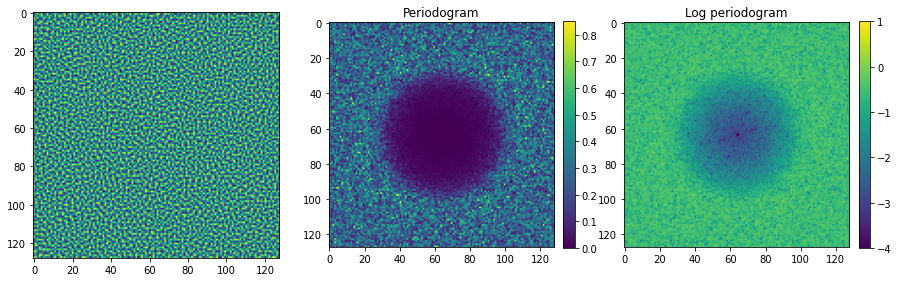

In [24]:
def plotFFT(pattern):
  fig, axs = plt.subplots(1, 3, figsize=(15, 10))
  axs[0].imshow(pattern)
  axs[1].set_title('Periodogram')
  im = axs[1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(pattern - np.mean(pattern))/ pattern.shape[0])), vmin=0.0, vmax=0.85)
  fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
  axs[2].set_title('Log periodogram')
  eps = 1e-12
  im = axs[2].imshow(np.log10(abs(np.fft.fftshift(np.fft.fft2(pattern - np.mean(pattern))/ pattern.shape[0]))+eps), vmin=-4, vmax=1)
  fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
  plt.show()

plotFFT(void_and_cluster(128))

In [25]:
%timeit void_and_cluster(128)

1 loop, best of 5: 3.28 s per loop
